# Basic Setup

Set up Basic Parameter here

In [25]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd


In [26]:
# Define sample size
N = 20000 # number of subjects
N_T = 10000 # number of treated subjects

# Define betas
beta_11 = 2
beta_12 = 2
beta_21 = 2
beta_22 = 2
beta_23 = 2
beta_31 = 2


#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 12

#Define strata size
N_S = 100


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



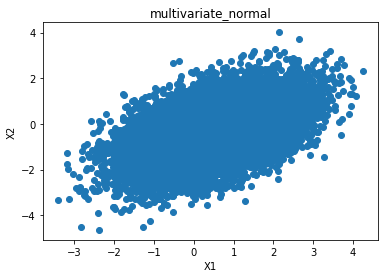

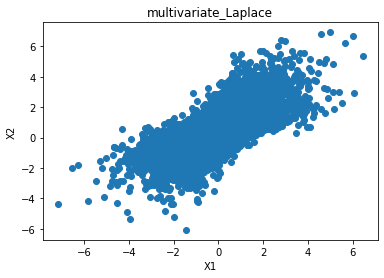

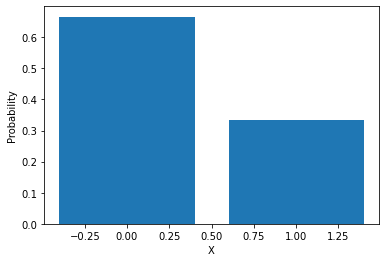

[[-0.56819372 -0.46613983 -0.24059548  1.32634354  0.        ]
 [-0.82031166 -2.09347074 -1.22829533 -2.73860836  0.        ]
 [ 0.68460491  0.49191105 -1.02230702 -0.34736644  0.        ]
 ...
 [ 3.34150692  1.00174686 -1.42936604 -0.40752735  1.        ]
 [-0.08208878 -0.29631347 -0.23569514  0.29084603  0.        ]
 [ 0.278644   -1.12629389  1.45632327  0.77254087  0.        ]]


In [27]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [28]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

U


array([[ 0.16693641,  1.        ],
       [ 0.60396699,  0.        ],
       [-0.587115  ,  1.        ],
       ...,
       [ 0.98133037,  1.        ],
       [-0.2284343 ,  1.        ],
       [ 0.32753362,  0.        ]])

# Simulate Z
The observed treatment indicators $\mathbf{Z}=(Z_{1}, \dots, Z_{N})\in \{0, 1\}^{N}$ follow a completely randomized experiment: $P(\mathbf{Z}=\mathbf{z})={N\choose N_{T}}^{-1}$ for any $\mathbf{z}=(z_{1},\dots, z_{N})\in \{0,1\}^{N}$ with $\sum_{n=1}^{N}z_{n}=N_{T}$.

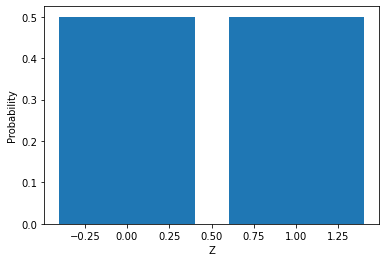

array([0., 1., 0., ..., 0., 1., 0.])

In [29]:
Z = np.zeros(N)
Z[:N_T] = 1
np.random.shuffle(Z)

counts = np.unique(Z, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('Z')
plt.ylabel('Probability')
plt.show()
Z = Z.reshape(-1,)
Z

# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [30]:
#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])


# Calculate Y_n1
Y_n1 = (beta_11 * Z + beta_12 * Z * sum1   + sum2 + np.sin(U_n1) + U_n2) 

# Compute Yn2
Y_n2 = (beta_21 * Z + beta_22 * Z * X[:,0] + beta_23 * Z * U_n1 * U_n2 + sum3 + sum4) 

# Compute Yn3
Y_n3 = (beta_31 * Z + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)) 

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1) 
print(Y.shape)

(20000, 3)


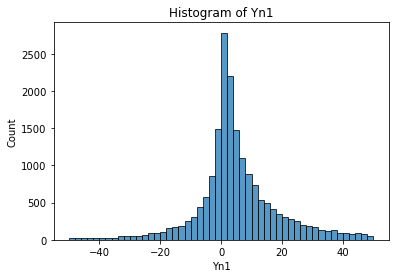

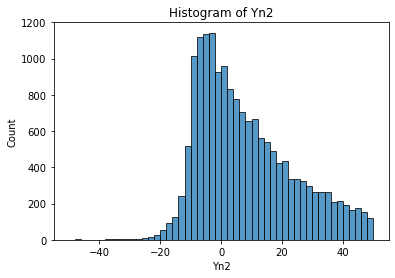

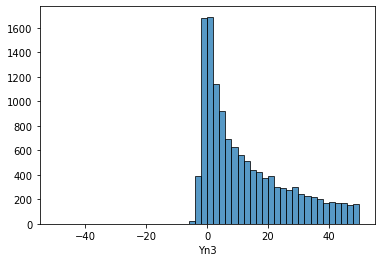

In [31]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [32]:

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3, single = True):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 - single
        else:
          M[i][0] = 0
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] =  1 - single
        else:
          M[i][1] =  0

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] =  0
        else:
          M[i][2] =  1

    return M,M_lamda
M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_93715/2862711778.py:31: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_93715/2862711778.py:43: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_93715/2862711778.py:27: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_93715/2862711778.py:33: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:


,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,0.0,0.0,1.0
19997,0.0,0.0,0.0
19998,0.0,0.0,1.0


[[ 1.14963489e+01  2.87610579e+00  5.21053704e+00]
 [-9.46672865e+01 -4.45181723e+05 -4.41608170e+02]
 [ 7.23947780e+00 -9.13691462e-01 -1.90719216e+00]
 ...
 [ 1.63422117e+24  8.68265059e+04  1.43520864e+54]
 [ 7.71394697e+00 -1.39614034e+00  4.59080488e-01]
 [ 3.92709468e+02  1.20137878e+02  7.63541281e+04]]


[ 1.14963489e+01 -9.46672865e+01  7.23947780e+00 ...  1.63422117e+24
  7.71394697e+00  3.92709468e+02]
[11.49634887  2.87610579  5.21053704]


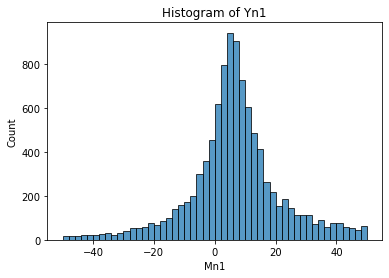

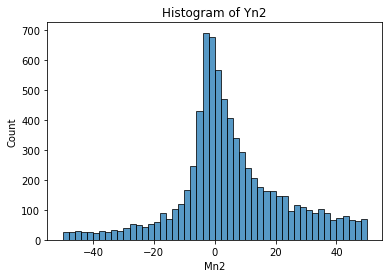

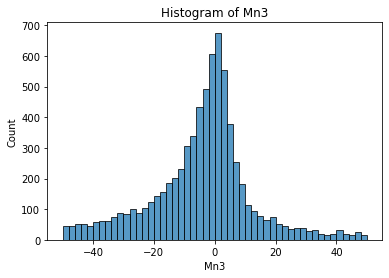

In [33]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [34]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.0
0.0
0.37185


# Add strata index

In [35]:
#add strata index to the data, each strata has 100 samples, 50 Z = 1 and 50 Z = 0
S = np.zeros((N,1))
Z0_counter = 0
Z0_index = 0
Z1_counter = 0
Z1_index = 0

#once Z0_counter = 50 ---> Z0_index += 1 and Z0_counter = 0
for i in range(N):
    if Z[i] == 0:
        Z0_counter += 1
        if Z0_counter == 50:
            Z0_index += 1
            Z0_counter = 0
        S[i] = Z0_index
    else:
        Z1_counter += 1
        if Z1_counter == 50:
            Z1_index += 1
            Z1_counter = 0
        S[i] = Z1_index
    

# Save all the simulated data


In [36]:
# Read the data,it is important to put the "Research" directory in ones own google drive
Z = Z.reshape((-1,1))

np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)
np.save("/Users/jiaweizhang/research/data/S.npy", S)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())
print(S.shape)
display(pd.DataFrame(S))
print(pd.DataFrame(S).describe())

print("Sucessfully Saved")

(20000, 5)


,0,1,2,3,4
0,-0.568194,-0.466140,-0.240595,1.326344,0.0
1,-0.820312,-2.093471,-1.228295,-2.738608,0.0
2,0.684605,0.491911,-1.022307,-0.347366,0.0
3,1.098139,0.299642,0.659859,1.731449,0.0
4,1.040119,1.957663,0.121841,0.579648,0.0
...,...,...,...,...,...
19995,-0.173545,-0.257993,-0.165383,0.585645,0.0
19996,0.215889,-1.429618,0.545997,0.672668,0.0
19997,3.341507,1.001747,-1.429366,-0.407527,1.0
19998,-0.082089,-0.296313,-0.235695,0.290846,0.0


                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.499547     -0.340845      0.009241      0.590204      0.334100
std        1.004425      1.003735      1.004443      1.010401      0.471687
min       -3.407298     -4.646735     -7.160971     -6.069474      0.000000
25%       -0.181302     -1.020018     -0.487571      0.097954      0.000000
50%        0.492805     -0.346746      0.000394      0.583191      0.000000
75%        1.180476      0.341978      0.505390      1.080112      1.000000
max        4.238115      4.017910      6.443836      6.931567      1.000000
(20000, 3)


,0,1,2
0,1.287357,-0.394869,-1.877866
1,-96.203544,-9.783777,90.253126
2,0.083591,0.306267,1.167530
3,18.007159,47.681528,185.336776
4,21.001501,50.398716,192.522661
...,...,...,...
19995,0.893728,-0.264757,-0.851036
19996,0.716170,-0.238210,-1.458231
19997,55.753209,124.700905,431.140090
19998,0.697685,-1.426942,-0.096638


                  0             1              2
count  20000.000000  20000.000000   20000.000000
mean       9.639636     35.542715     242.599283
std       40.055097    258.205341    3256.695533
min     -824.830353    -55.797808      -5.869558
25%       -0.563166     -2.954767       4.146370
50%        3.447253      8.837139      22.738140
75%       12.983628     31.626425      93.477574
max     1102.260982  15996.458424  231784.052882
(20000, 1)


,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
19995,1.0
19996,1.0
19997,0.0
19998,1.0


                  0
count  20000.000000
mean       0.500000
std        0.500013
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
(20000, 2)


,0,1
0,0.166936,1.0
1,0.603967,0.0
2,-0.587115,1.0
3,-1.147032,1.0
4,0.551957,1.0
...,...,...
19995,-0.101179,1.0
19996,-0.302441,1.0
19997,0.981330,1.0
19998,-0.228434,1.0


                  0             1
count  20000.000000  20000.000000
mean       0.511295      0.664300
std        1.001268      0.472246
min       -3.198552      0.000000
25%       -0.155549      0.000000
50%        0.515679      1.000000
75%        1.174589      1.000000
max        4.581157      1.000000
(20000, 3)


,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,0.0,0.0,1.0
19997,0.0,0.0,0.0
19998,0.0,0.0,1.0


             0        1             2
count  20000.0  20000.0  20000.000000
mean       0.0      0.0      0.371850
std        0.0      0.0      0.483311
min        0.0      0.0      0.000000
25%        0.0      0.0      0.000000
50%        0.0      0.0      0.000000
75%        0.0      0.0      1.000000
max        0.0      0.0      1.000000
(20000, 1)


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
19995,199.0
19996,199.0
19997,199.0
19998,200.0


                  0
count  20000.000000
mean      99.520000
std       57.735918
min        0.000000
25%       50.000000
50%      100.000000
75%      150.000000
max      200.000000
Sucessfully Saved
